# Lab 6 Generative models

This notebook has been prepared by Hsiu-Wen Chang from MINES ParisTech
Shall you have any problem, send me [email](hsiu-wen.chang_joly@mines-paristech.fr)

In this practical lesson, we will use Pytorch to learn autoencoder in order to understand the limitations of it. Then the second part introduces variational autoencoder to show how we can genrate new synthetic images from some unknown (but learnable from givien images) distribution P 

To run this code, you can follow these command to have your virtual environment. If you have a GPU, make sure the your cuda version when you install pytorch
* conda create --name lightning_env python=3.7 jupyter
* conda activate lightning_env
* conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch
* pip install -r requirements.txt

## Part 1: Autoencoder

Encoder is a process that produces `new features` representation from the `old features`, either by selection or extraction, and decoder the reverse process. When the dimension of the new features (n_d) is relative low compare to the dimension of the old feature (n_e), we call this Dimensionality reduction. This is a popular processfor for data compression such as video, audio, etc. The main purpose of dimensionality reduction is to find the best encoder/decoder pair among a give family. 

Hereafter, we denote E and D as the families of encoders and decoder, respectively. We define the reconstruction error measures between the input data $x$ and the encoder data $d(e(x))$ as $\epsilon(x,d(e(x))$. Then we can formulate this problem as:

$$(e^*,d^*) = \underset{(e,d)\in ExD}{\operatorname{argmax}}{\epsilon(x, d(e(x)))}$$

The general idea of autoencoders is simple that we try to learn the best encorder $e^*$ and decoder $d^*$ as neural networks using an iterative optimisation processs.

In [1]:
# Fundamental packages
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import copy
import torch.nn as nn
import torch.nn.functional as F
import os

Here we are going to try simple hand writing digits images (MNIST) in small size of gray images. Later on, we will move to use colorful and and more complicated images. 

In [2]:
batch_size_train = 10
batch_size_test = 100

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('~/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Now we should check the data before we define our model

Loaded image shape in tensor [N,C,H,W]: torch.Size([10, 1, 28, 28])


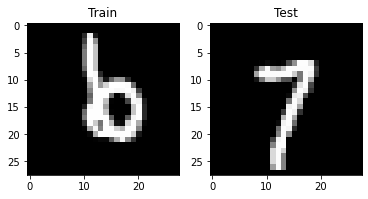

In [3]:
# get minibatch
x,target = next(iter(train_loader)); x_test,_ = next(iter(test_loader))
print('Loaded image shape in tensor [N,C,H,W]:', x.size())
fig,axes = plt.subplots(1,2); 
# Here is the code to change colormap
# If you want to see the intensity of pixel in a better way, use plt.set_cmap(['gray','viridis'][1]);
plt.set_cmap(['gray','viridis'][0]);
axes[0].imshow(x[0][0].numpy()); axes[1].imshow(x_test[0][0].detach().numpy());
axes[0].set_title('Train'); axes[1].set_title('Test');

In [4]:
# This is the simplest way to feed images to AE by flat 2D to 1D
input_size = 784

# Hyperparameters
encoding_dim = 32
learning_rate = 0.01
momentum = 0.5
log_interval = 10
n_epochs = 3

Now let's create a simple encoder that consists one linear layer with ReLU activation as well as one decoder that consists one linear layer. Then we create an autoencoder that consists one encoder and one decoder. Pay attention that we will use sigmoid function to make sure the reconstructed pixels are within normalized range. 

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super().__init__()
        self.layers = nn.ModuleList(
            [nn.Linear(input_size, encoding_dim), 
             nn.ReLU()])
    def forward(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self, encoding_dim, input_size):
        super().__init__()
        self.layers = nn.ModuleList(
            [nn.Linear(encoding_dim, input_size)])
    
    def forward(self,z):
        for layer in self.layers:
            z = layer(z)
        return z

class Autoencoder(nn.Module):
    def __init__(self, input_size = 784, encoding_dim = 32):
        super().__init__()
        self.encoder = Encoder(input_size, encoding_dim)
        self.decoder = Decoder(encoding_dim, input_size)
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten to (nm, 1) vector
        x = self.encoder(x) # here we get the latent z
        x = self.decoder(x) # here we get the reconsturcted input
        x = torch.sigmoid(x)
        x = x.reshape(x.size(0), 1,28,28) # reshape this flatten vector to the original image size    
        return x
    
        

In [6]:
# Now we creat and initialize a autoencoder
autoencoder = Autoencoder(784,32)

Here is what the initial autoencoder generates.

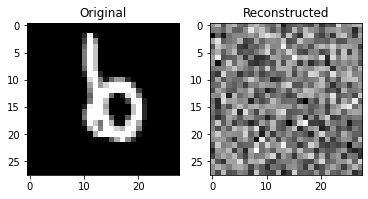

In [7]:
fig,axes = plt.subplots(1,2); plt.set_cmap(['gray','viridis'][0]);
axes[0].imshow(x[0][0].numpy()); axes[0].set_title('Original'); 
axes[1].imshow(autoencoder(x)[0][0].detach().numpy()); axes[1].set_title('Reconstructed');

Addition materials about ploting images in grid so we can see more examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed images')

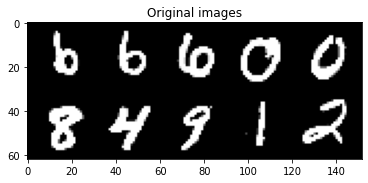

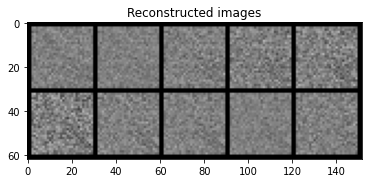

In [8]:
# Here we can also use make_grid function to plot images
# In Pytorch, the shape of images are (N,C,H,W) 
# make_grid return arrays in (C, Hs, Ws)
# In matplotlib, we need (H,W,C)
from torchvision.utils import make_grid

ims = make_grid(x, nrow=5).permute(1,2,0).numpy()
plt.imshow(ims); plt.title('Original images')

with torch.no_grad():
    reconstruct_ims = autoencoder(x).cpu()

ims_rec = make_grid(reconstruct_ims, nrow=5).permute(1,2,0).numpy()
plt.figure()
plt.imshow(ims_rec); plt.title('Reconstructed images')

Now we move to define how our autoencoder should be trainned. In this function of `train` we directly include the test data process at the end of training. 

In [9]:
def train(model, trainloader = None, valloader = None, num_epochs = 1):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    # name dataloaders for phrase
    phases = ['train']
    dataloaders = {'train':trainloader}
    if valloader:
        phases.append('valid')
        dataloaders['valid'] = valloader
        
    model.to(device)
    optimizer = torch.optim.Adadelta(autoencoder.parameters())
    criterion = torch.nn.BCELoss() #binary cross entropy 
    
    train_hist, valid_hist = list(),list()
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}\n{"-"*10}')
        
        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss, running_correct, count = 0.0, 0, 0
            for batch_idx, (x, y) in enumerate(dataloaders[phase]):
                x,y = x.to(device), y.to(device)

                # zero param gradients
                optimizer.zero_grad()

                # forward: track history if training phase
                with torch.set_grad_enabled(phase=='train'): # pytorch >= 0.4
                    outputs = model(x)
                    loss    = criterion(outputs, x)
                    # backward & optimize if training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # stats
                running_loss += loss.item() * x.size(0)
                count += len(x)
            
            epoch_loss = running_loss / count
            
            exec('%s_hist.append(%d)' % (phase, epoch_loss))
            print(f'{phase} loss {epoch_loss:.6f}')
        print()
    plt.plot(train_hist, label='train_loss')
    plt.plot(valid_hist,label='valid_loss')
    plt.legend()    
    plt.tight_layout()

In [10]:
%time train(autoencoder, trainloader=train_loader, valloader=test_loader, num_epochs=3)

KeyboardInterrupt: 

Now we can plot the result of autoencoder to see how closs these two images are

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed images')

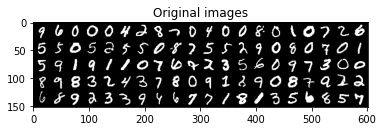

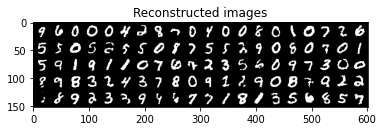

In [ ]:
x,_ = next(iter(test_loader))
#z = autoencoder(x)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
x = x.to(device)
with torch.no_grad():
    reconstruct_ims = autoencoder(x).cpu()

ims_ori = make_grid(x.cpu(), nrow=20).permute(1,2,0).numpy()
plt.imshow(ims_ori)
plt.title('Original images')

plt.figure()
ims = make_grid(reconstruct_ims, nrow=20).permute(1,2,0).numpy()
plt.imshow(ims)
plt.title('Reconstructed images')

## Limitation of autoencoder
In the above example, our encoder and decoder architectures have only one layer without non-linearity. Such encoder-deocoder represent linear transformations (the sigmoid function can be removed since it is simply the function to accelerate the training). It is worth mentioning that Principle Componet Anaysis (PCA) defines one of the soltuions (basis) that satisfied the minimum of reconstruction error. For our autoencoder, indeed, can have several basis that describe the same optimal subspace. It ends up that the new features do not have to be independent.

With deeper and more complex architectures, the more the autoencoder can processed to high dimensionality reduction while keeping reconstruction loss low. It invokes an impoartant issue in traditional autoencoder: **the lack of interpretable and exploitable structures in the latent space**. Beside, once the autoencoder has been trained, we still have no way to produce any new content based on the trained latent space. 

Key to solve this issue: get the distribution of latent space so we can generate samples from this space ==> **Variational Autoencoders (VAE)**
![](AE_VAE.png)

### Task 1:
Change your encoder and decoder to use 2D convolutional layers.

## Part 2: Variational Autoencoder
*Credits goes to William Falcon from NYU who created this nice [code](https://colab.research.google.com/drive/1_yGmk8ahWhDs23U4mpplBFa-39fsEJoT?usp=sharing#scrollTo=EYDKIsTtk3hJ)

### Objective
The objective of VAE is to have a vector $z$ in a high-dimensional space $Z$ which we can easily sample according to some probability density distribution $P(z)$ defined over $Z$. In addition, we want to train parameters ($\theta$) such that the function $f(z;\theta)$ will be like the input dataset.

In another word, we sample a value $z$ from a probability distribution $P(z|x)$ and we reconstruct a data $\hat{x}$ by passing z to a decoder $d$. The goal is to make the $\hat{x}=d(z)$ and $x$ as close as possible. In VAE, we estimate a distribution $P(x|z,\theta)$. Therefore, we are aiming maximizing the probability of each $X$ under the entire generative process called Maximum likelihood
$$P(x)=\int{P(x|z,\theta)P(z)dz}$$
However, it is intractable. The solution is proposed by [Kingma et Welling 2014](https://arxiv.org/abs/1312.6114). The final derivative of loss function for VAE is:
$$
\color{red}{\min \mathbb{E}_{q}[ \log q(z|x) - \log p(z)]} - \color{blue}{\mathbb{E}_{q} \log p(x|z)}
$$
Here the blue term is the reconstructed error and the red term is the KL divergence

The following usage of Pytorch lightning is optional but recommend to accelerate your learning progress
[Pytorch lightning Bolts](https://lightning-bolts.readthedocs.io/en/stable/) is a very useful tool for getting prebuits models across many reserach domains

In [ ]:
# You might not use pytorch-lightning if you have installation issues. A known issue is between python 3.6 and gym
# If you get error "module 'contextlib' has no attribute 'nullcontext'",
# You have a incompatable issue between python and gym. Try to update to python 3.7

# Pytorch-lightning will accelearte the training by automatically access GPU or TPU. 
# !pip install pytorch-lightning==1.0.8
%pip install pytorch-lightning

# Pytorch lightning Bolts is a collection of prebuilt models across many reserach domains
%pip install wandb
%pip install gym
%pip install pytorch-lightning-bolts

We are going to use CIFAR10 images (6000 colorful images in 3x32x32 pixels and 10 different classes). To enable the network in learning this kind of problem, we need to use a better layer instead of Linear. Here we will use [resnet18](https://arxiv.org/pdf/1512.03385.pdf) (deep residual networks with 18 layers pre-trained on ImageNet) to accelerate our learning. Be aware, images from ImageNet is 3x224x224 and images from Cifar are only 3x32x32. This is the reason we disable first layer and it's maxpooling.  

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

# Use pytorch_lightning dataloader. This class normalize images with parameter (mu=0.5, std=0.5)
# Random divided images to 45000 and 5000 for training and validation
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from torchvision import transforms

TypeError: Expected 'Iterator' as the return annotation for `__iter__` of ExperienceSourceDataset, but found typing.Iterable

In [ ]:
dm = CIFAR10DataModule(".", normalize=True)
dm.prepare_data()
dm.setup("fit")
dataloader = dm.train_dataloader()

In [ ]:
X, _ = next(iter(dataloader))
print(X.shape)

torch.Size([32, 3, 32, 32])


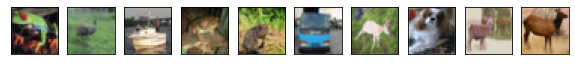

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):  
  axes[i].imshow(np.transpose(unnormalize(X[i]), (1, 2, 0)))
  axes[i].get_xaxis().set_visible(False)
  axes[i].get_yaxis().set_visible(False)

In [ ]:
class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False) #arguments (first_conv, maxpool1)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

Now we start to sample z. Beaware, pytorch lightning provides more concise way to use VAE and training. For the education purposes, we are adding the training step to the lightning module instead of the original class definition

In [ ]:
vae = VAE()

### Encoding
For educational purpose, we will show you the variables and procedure step by step

In [ ]:
# pretend we have an colorful image (3 chanels, 32x32 pixels)
#x = torch.randn(1,3,32,32)
x = X[[0]]
print(x.shape)
#Get q(z|x) parameters
x_encoded = vae.encoder(x)
print('Encoded x shape:', x_encoded.shape)

# Now we use the final fully connected layer of encoder to get the parameters (mu, var) of q(z|x) distribution 
mu, log_var = vae.fc_mu(x_encoded),vae.fc_var(x_encoded)
print('mu:', mu.shape)
print('log_var:',log_var.shape)

# sample z from q(z|x)
std = torch.exp(log_var/2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()

print('z shape:', z.shape)

torch.Size([1, 3, 32, 32])
Encoded x shape: torch.Size([1, 512])
mu: torch.Size([1, 256])
log_var: torch.Size([1, 256])
z shape: torch.Size([1, 256])


### decoding
The decoder is going to take sampled z as input and it will generate parameters for a distribution from which to sample a reconstruction. 

In [ ]:
x_hat = vae.decoder(z)
print('x_hat shape:', x_hat.shape)

x_hat shape: torch.Size([1, 3, 32, 32])


#### Reconstructed loss
You might see other open-source code of VAE use MSE as reconstructed loss. However, pay attention that it is only valid when the images are gray (binary variables). The parameters of decoder ouput in that case will be bernoullis distribution and thus we can use the pixel values to calculate the cross entropy. 

In [ ]:
recon_loss = F.mse_loss(x_hat, x, reduction='none')
recon_loss = recon_loss.sum(-1).sum(-1).sum(-1)
print('Reconstructed loss uing cross entropy (wrong one in our case!):', recon_loss)

Reconstructed loss uing cross entropy (wrong one in our case!): tensor([8311.9189], grad_fn=<SumBackward1>)


When we deal with data that has more than one channels (in our example, 3 channels), it is preferred to model each parameter out of the decoder as a gaussian.

In [ ]:
# compute the probability of x under this n-dimensional distribution
log_scale = nn.Parameter(torch.Tensor([0.0]))
scale = torch.exp(log_scale)
# p(x|z)
dist = torch.distributions.Normal(x_hat, scale)
# Reconstructed loss: Exp_q(log(p(x|z)))
log_pxz = dist.log_prob(x)
print('shape of log(p(x|z):',log_pxz.shape)
# We use Monte carlo sampling theory to do Exp: 
# Sum across all the channels and pixels
log_pxz = log_pxz.sum(dim=(1,2,3))
print('Reconstructed error:', log_pxz.item()) 

shape of log(p(x|z): torch.Size([1, 3, 32, 32])
Reconstructed error: -6978.9384765625


#### KL divergence
Here we use monte carlo estimate.

$$
= \mathbb{E}_{q} [\log q(z|x) - \log{p(z)}]\\
=\mathbb{\sum}[\log q(z_i|x)-\log{p(z_i)}]
$$

In [ ]:
# 1. define the first two probabilities (in this case Normal for both)
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
q = torch.distributions.Normal(mu, std)

# 2. get the probabilities from the equation
log_qzx = q.log_prob(z)
log_pz = p.log_prob(z)

print('Shape of q(z|x):',log_qzx.shape)
print('Shape of p(z):', log_pz.shape)

# 3. calculate the KL
kl = (log_qzx - log_pz)

# 4. this bit is a bit tricky. Since these are log probabilities
# we can sum all the individual dimensions to give us the multi-dimensional
# probability
kl = kl.sum(-1)

Shape of q(z|x): torch.Size([1, 256])
Shape of p(z): torch.Size([1, 256])


In [ ]:
# The final ELBO loss:
elbo = (kl - recon_loss)
print('kl:', kl.mean())
print('log likelihood (reconstruction loss):', recon_loss.mean())
print('elbo: ', elbo.mean())

kl: tensor(37.4255, grad_fn=<MeanBackward0>)
log likelihood (reconstruction loss): tensor(8311.9189, grad_fn=<MeanBackward0>)
elbo:  tensor(-8274.4932, grad_fn=<MeanBackward0>)


Here we create a plot function that can visualize the result


In [ ]:
def images_original_generated(x, x_hat, normalize):
    mean, std = np.array(normalize.mean), np.array(normalize.std) 
    x_com = torch.cat((x,x_hat),0).detach()
    grid =torchvision.utils.make_grid(x_com).permute(1, 2, 0).numpy() * std + mean
    return grid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([2, 3, 32, 32])


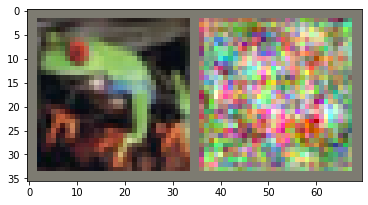

In [ ]:
grid = images_original_generated(x,x_hat,cifar10_normalization())
plt.imshow(grid)

Now we can assemble all the functions into one class

In [1]:
#Full implementation of VAE
import torch

class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()
        self.img_dim = (3,32,32) #RGB images
        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr = 1e-4)

    # Reconstruction loss: P(x|z)
    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    # sum(log(q(z|x)-log(p(z)))
    def kl_divergence(self, z, mu, std):
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl
    
    #def forward(self,z):
    #    img = self.decoder(z)
    #    img = img.view(img.size(0),*self.img_dim)

    def training_step(self, batch, batch_idx):
        x,_=batch
        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        #sample z from q(z|x)
        std = torch.exp(log_var/2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        #decoded
        x_hat = self.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        #kl
        kl = self.kl_divergence(z, mu, std)

        #elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        # log sampling images
        grid = images_original_generated(x,x_hat,cifar10_normalization())
        self.logger.experiment.add_image("generated images-{epoch:02d}", grid, 0)
        
        return elbo

NameError: name 'pl' is not defined

Now let's use CIFAR-10 provided from pl_bolts and start to train our VAE

In [ ]:
os.makedirs("temp",exist_ok = True)
datamodule = CIFAR10DataModule('temp')

In [ ]:
pl.seed_everything(1234)

vae = VAE()
trainer = pl.Trainer(gpus=1, max_epochs=18, progress_bar_refresh_rate=10)

trainer.fit(vae, datamodule)

Global seed set to 1234


MisconfigurationException: You requested GPUs: [0]
 But your machine only has: []

Visualize the resutls

In [ ]:
#start tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [ ]:
from matplotlib.pyplot import imshow, figure
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=300)

# Z COMES FROM NORMAL(0, 1)
num_preds = 16
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
z = p.rsample((num_preds,))

# SAMPLE IMAGES
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

# UNDO DATA NORMALIZATION
normalize = cifar10_normalization()
mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred).permute(1, 2, 0).numpy() * std + mean

# PLOT IMAGES
imshow(img);